# Compression and Generation

In this notebook I explore and show examples of using traditional methods and (variational) autoencoders to compress and generate images. 

## Dataset

In [213]:
import torchvision
import torch
from torchvision.transforms import Lambda, ToTensor

# Grayscale for debugging
# dataset = torchvision.datasets.LFWPeople('./',download=True,image_set='deepfunneled',transform=Lambda(lambda y:  torchvision.transforms.Grayscale(3)(ToTensor()(y))) )
# 3 Color
dataset = torchvision.datasets.LFWPeople('./',download=True,image_set='deepfunneled',transform=Lambda(lambda y:  ToTensor()(y)) )

Files already downloaded and verified


Explore some of the basics of working with this dataset. This is similar to some PyTorch examples that I've done.

I'm going to try and do the dimensionality reduction and compression shown [here](http://www.databookuw.com/page-2/page-4/). There's also a great [YouTube Video](https://www.youtube.com/watch?v=gXbThCXjZFM&list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv&index=1) (and whole playlist) about the method I'm going to use. I'll leave the thorough explanation to those sources, but provide a brief description of what we are going to do.

We can load a batch of data $X\in \mathbb{R}^{\text{batch size} \times 3 \times 250 \times 250}$. As discussed in class, images are tensors. A batch of images is also a tensor. We can reshape this tensor to the following form $\mathbf{X} \in \mathbb{R}^{(3 \cdot 250 \cdot 250) \times \text{batch size}}$, or in other words, $\mathbf{X}$ is a matrix of our batch of images, with each column representing an entire image. Matrices are also tensors, but we will distinguish between these two representations as "Tensor" vs "Matrix".

We will summarize the images in this matrix by taking the [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD). This matrix factorization technique is similar to an Eigendecomposition, but it generalizes for rectangular matrices, like we have here. It is similar to Principal Component Analysis, which would also be worth investigating here.

### Load from the tensor form

torch.Size([256, 3, 250, 250])


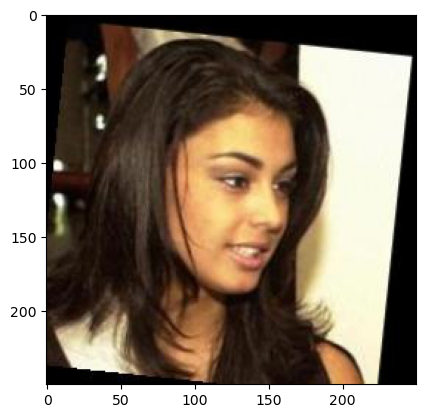

In [214]:
import matplotlib.pyplot as plt

batch_size = 256
data_loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=batch_size)
for data in data_loader:
    imgs = data[0]
    labels = data[1]
    shape = imgs.shape
    print(shape)
    plt.imshow(torch.permute(imgs[0,:,:,:],(1,2,0)))
    break

### Convert to the Matrix form and show how to convert back

This actually was a source of big problems when I was trying to write the code. In order for what I'm doing to work, the `reshape` function needs to be consistent between samples. Before, I was trying to reshape the entire batch at once, and that is different than reshaping each sample in the batch independently.

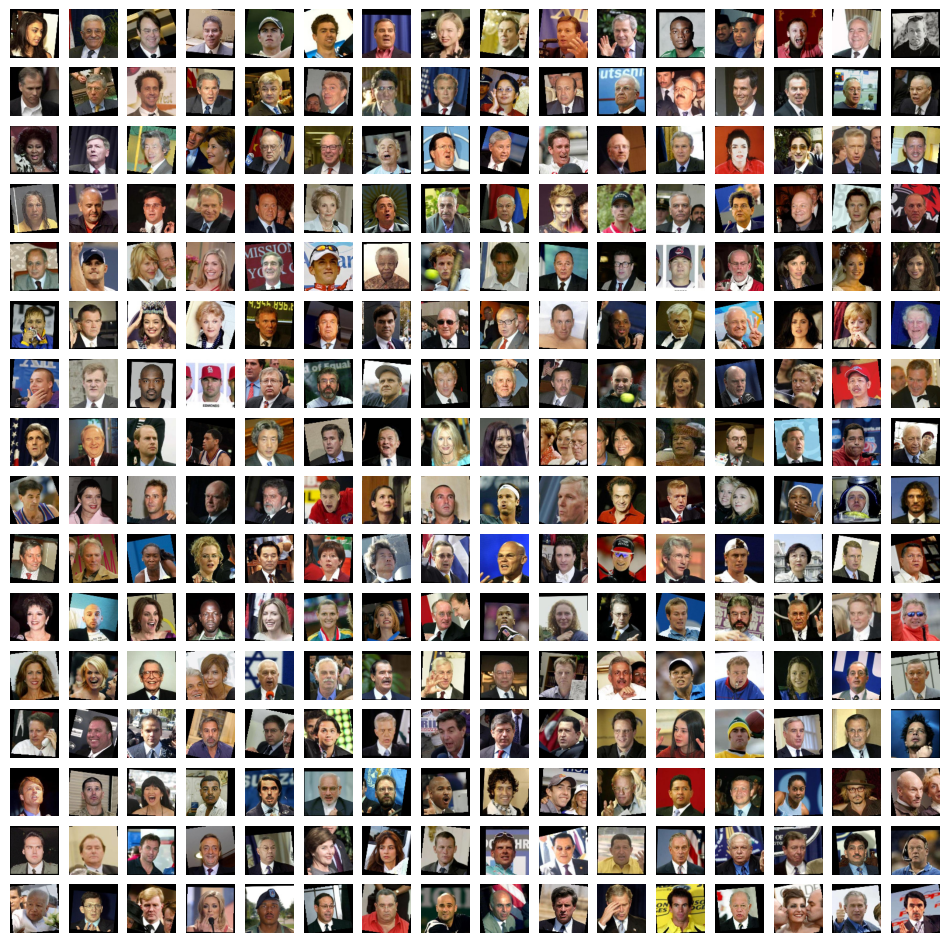

In [215]:
# Subsample so that I don't break my computer with memory.
step = 3
subsample = torch.arange(0,shape[-1],step)
imgs_subsample = imgs[:,:,subsample,:]
imgs_subsample = imgs_subsample[:,:,:,subsample]

n_x = len(imgs_subsample[0,0,:,0])
n_y = len(imgs_subsample[0,0,0,:])
shape_subsample = [batch_size,list(shape)[1],n_x,n_y]

# Create a shape representation for when we want to look at a single image, rather than batch
shape_subsample1 = shape_subsample.copy()
shape_subsample1[0] = 1

m = n_x*n_y*shape_subsample[1]
X = torch.zeros(m,batch_size)

# Just some plotting details
split = 16
mult = 0.75
f = plt.figure(figsize=(split*mult,batch_size//split*mult))

for batch in range(batch_size):
    img = imgs_subsample[batch,:,:,:] 
    X_col = torch.reshape(img,(m,1))
    X[:,batch:batch+1] = X_col

    img = torch.reshape(X_col,shape_subsample1)

    plt.subplot(batch_size//split,split,batch + 1)
    plt.imshow(torch.permute(img[0,:,:,:],(1,2,0)))
    plt.axis('Tight')
    plt.axis('Off')

### PCA/SVD

The SVD is not unique, so we choose the ordering from most important to least important (the default). The returned singular values are decreasing (becoming less important) over the indices.

[1, 3, 84, 84]
torch.Size([21168, 256])


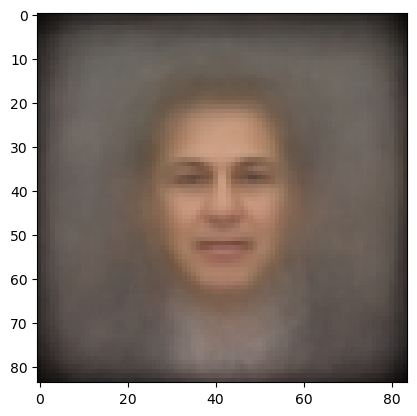

In [216]:
# Come up with the mean face:
X_mean = torch.mean(X,axis=1)
X_mean.unsqueeze_(axis=1)

print(shape_subsample_1)
mean_img = torch.reshape(X_mean,shape_subsample_1)
plt.imshow(mean_img.squeeze().permute((1,2,0)))


X_reg = (X - X_mean@torch.ones((1,batch_size)))
print(X_reg.shape)
U_or, S, Vh = torch.linalg.svd(X_reg,full_matrices=False)

torch.Size([21168, 256])
<built-in method size of Tensor object at 0x000001DFA02BFEA0>
Max U: 0.043991249054670334
Min U: -0.049256905913352966
Max U: 1.0
Min U: 0.0


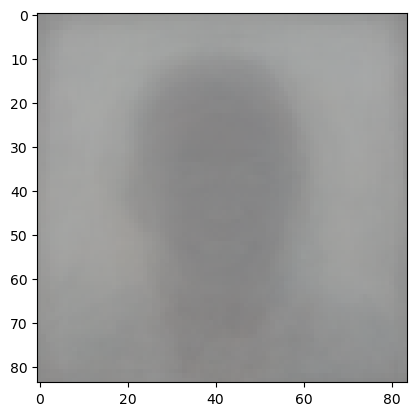

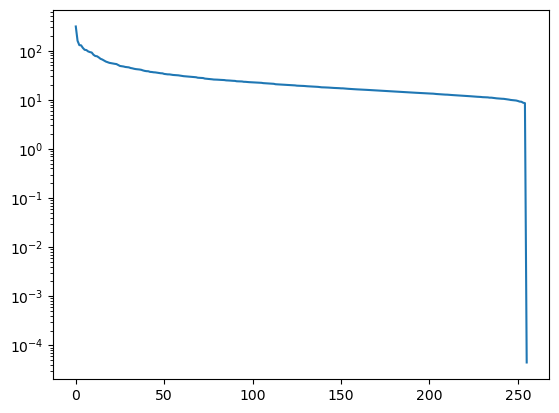

In [217]:
print(U_or.shape)

# rescale U?
min_U = torch.min(U_or)
max_U = torch.max(U_or)
print(max_U.size)
print(f'Max U: {max_U}')
print(f'Min U: {min_U}')

U = (U_or-(min_U)) / (max_U - min_U)
print(f'Max U: {torch.max(U)}')
print(f'Min U: {torch.min(U)}')
# print(f'Max X: {torch.max(X)}')
# print(f'Min X: {torch.min(X)}')
U1 = U[:,0]

U1_img = torch.reshape(U1,shape_subsample1)
plt.imshow(torch.permute(U1_img[0,:,:,:],(1,2,0)))

plt.figure()
plt.plot(S)
plt.yscale('log')

We don't see the image too well. Here's a quick way to exaggerate what is going on.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


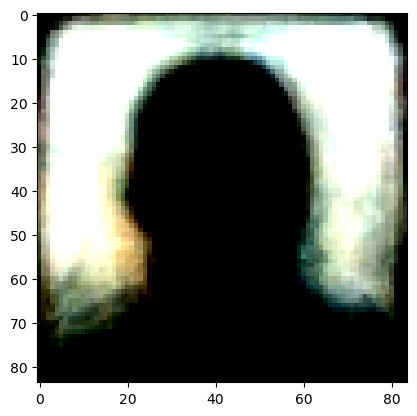

In [218]:
U1_exag = (U1-torch.mean(U1))/torch.std(U1)
U1_img = torch.reshape(U1_exag,shape_subsample1)
plt.imshow(torch.permute(U1_img[0,:,:,:],(1,2,0)))

Let's just look at all of the SVD Modes (as images).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

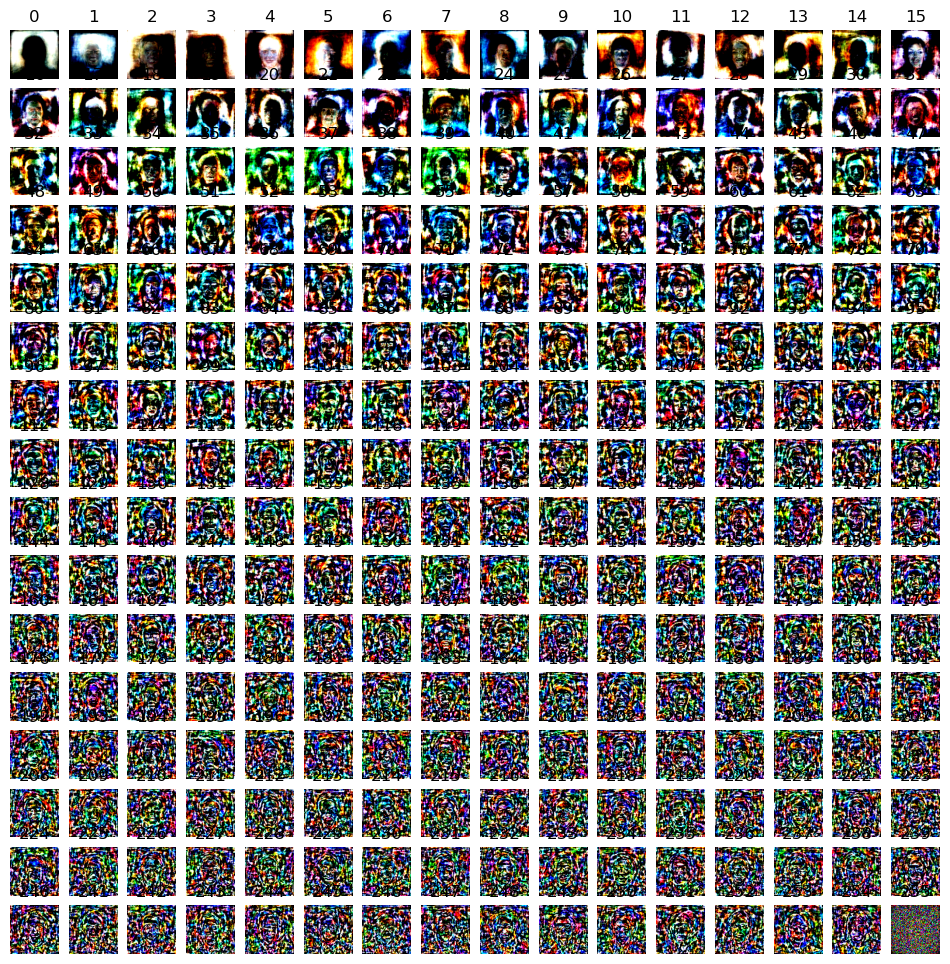

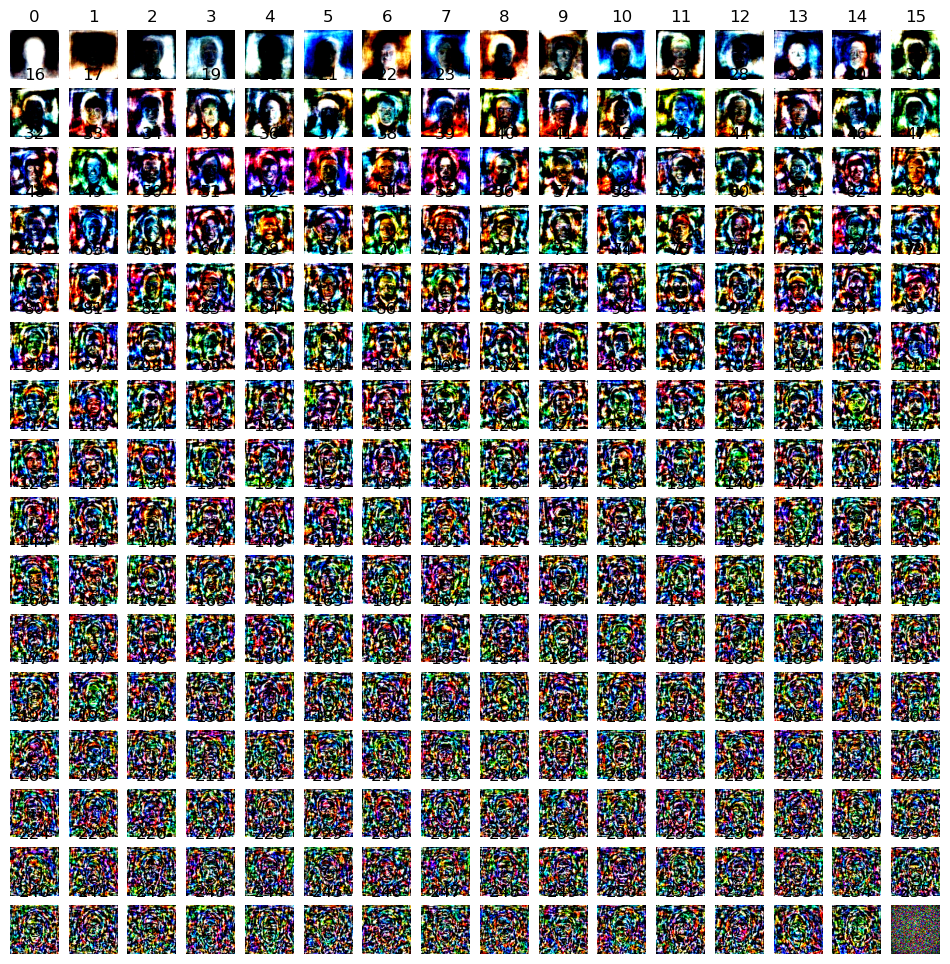

In [219]:
# Same format as above, but these aren't related to the same ordering of those images.
f = plt.figure(figsize=(split*mult,batch_size//split*mult))
for batch in range(batch_size):
    U1 = U[:,batch]

    U1_exag = (U1-torch.mean(U1))/torch.std(U1)
    U1_img = torch.reshape(U1_exag,shape_subsample1)
    # U1_img = torch.reshape(U1,shape_subsample_1)

    plt.subplot(batch_size//split,split,batch + 1)
    plt.imshow(torch.permute(U1_img[0,:,:,:],(1,2,0)))
    plt.axis('Tight')
    plt.axis('Off')


# Also plot the inverted mode images, in case they are scaled by a negative number
f = plt.figure(figsize=(split*mult,batch_size//split*mult))
for batch in range(batch_size):
    U1 = U[:,batch]

    U1_exag = (U1-torch.mean(U1))/torch.std(U1)
    U1_img = -torch.reshape(U1_exag,shape_subsample1)
    # U1_img = torch.reshape(U1,shape_subsample_1)

    plt.subplot(batch_size//split,split,batch + 1)
    plt.imshow(torch.permute(U1_img[0,:,:,:],(1,2,0)))
    plt.axis('Tight')
    plt.axis('Off')

We also see good behavior in the singular values when we have a large enough batch. We see that at some point the singular values quickly drop off, which means that we can represent the entire batch using less data. This is done by omitting the singular value modes that correspond to these small singular values. If you look at these modes (just like we looked at the first one), as you get closer to where the sharp dropoff begins, the images get weirder and weirder. That is, they look more vibrant, colorful, unpredictable (nightmarish). However, once you reach the dropoff, the singular value modes look appear as random noise. On the other hand, the earlier modes (bigger singular values) are much more coherent. Similar to the averaged face, we can see some common features. In particular, the first mode just outlines the head and shoulders, with a chin even visible. The second mode looks similar with some more details. Some of the next modes may look like individual faces, but they contain contributions from the entire batch. If a certain face is completely orthogonal to the rest of the batch already, then there will be a mode capturing this face. Similarly, if there is a face that does not have any features that other faces in the batch do, then this feature will be visible in one of the modes. Lastly, in the above, there is a chance that there is some changing of the images due to clipping. SVD normalizes the columns of the matrices (the images for $\mathbf{U}$), but for showing an image, we instead want the vector entries between $0$ and $1$. To show the details that would be lost by clipping, I show both the positive and negative versions of the modes (capturing all the information).

### Truncated SVD
If we make a reconstruction without using the bad singular value modes, we have compressed the images. The matrix dimensions and algebra is clarified [here](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.7674)
tensor(0.0279)
torch.Size([21168, 256])
tensor(1.0138)
tensor(-0.1507)
torch.Size([21168, 256])
tensor(1.1100)
tensor(-0.2075)
torch.Size([21168, 256])
tensor(1.1194)
tensor(-0.1703)
torch.Size([21168, 256])
tensor(1.0791)
tensor(-0.1057)
torch.Size([21168, 256])
tensor(1.0579)
tensor(-0.0647)
torch.Size([21168, 256])
tensor(1.0251)
tensor(-0.0299)
torch.Size([21168, 256])
tensor(1.0000)
tensor(-1.7732e-06)
torch.Size([21168, 256])


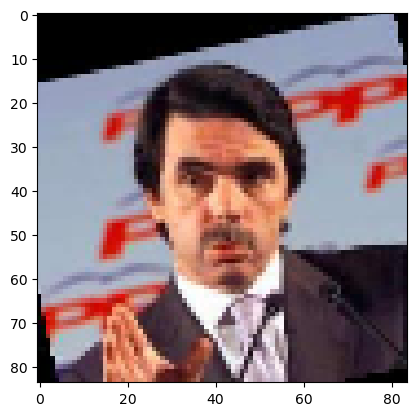

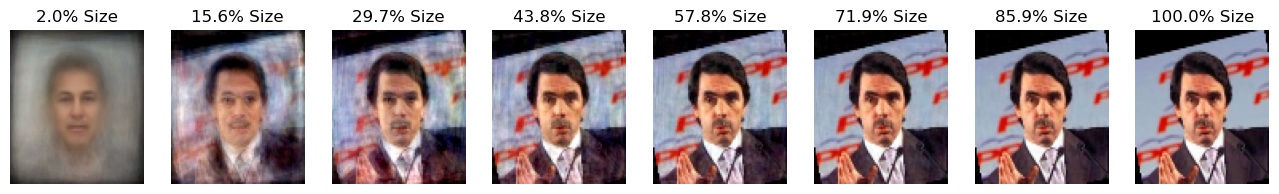

In [238]:
import numpy as np

# here's the last image.
plt.figure()
plt.imshow(torch.permute(img[0,:,:,:],(1,2,0)))

# reconstruct image
n_reductions = 8

plt.figure(figsize=(n_reductions*2+0.25,2))
# Rank to use (how many modes to include)
ts = np.linspace(5,batch_size,n_reductions)
for i in range(n_reductions):
    t = int(ts[i])
    X_r = U_or[:,0:t] @ torch.diag(S[0:t]) @ Vh[0:t,:]
    X1_r = X_r[:,-1:] + X_mean
    print(torch.max(X1_r))
    print(torch.min(X1_r))
    print(X_r.shape)
    img_r = torch.reshape(X1_r,shape_subsample1)

    # Full size uses t=batch_size.
    size = (t/batch_size)

    plt.subplot(1,n_reductions,i+1)
    plt.imshow(torch.permute(img_r[0,:,:,:],(1,2,0)))
    plt.axis('Tight')
    plt.axis('Off')
    plt.title(f'{size*100:3.1f}% Size')


We can store the entire batch using less data by using the truncated SVD. We store the top $t$ modes (where $t$ is chosen as where we truncate the singular values) from $\mathbf{U}$. We store the singular values (insignificant compared to the size of everything else). And finally, we store the weights of each of the modes specific to each image from $\mathbf{V}^*$. This is bigger than the singular values but still much smaller than the modes, $\mathbf{U}$. In other words, the total storage cost comes down to mostly just the size of $\mathbf{U}$ that we are storing.

### Attempt at Generation and Connection to Class

In class, we discussed adversarial images, and touched on generating fake images. So far, we have not done any of this. We have been focused on representing images using a lower dimensional space (the truncated modes from SVD). However, this lower dimensional space relies on the common modes that are shared between all the images in the batch. In other words, we've dissected the eseence of what is contained by these images. We can slightly alter this lower dimensional space, and the resulting image will be "close" to the input images. Here, "close" is defined as a norm ($\mathscr{l}^2$) over the image vector, which is different from how we perceive "close" when looking at images. Thus, I'm not expecting this to give us a realistic image!

For our new image, we know $\mathbf{U}$ and $\mathbf{\Sigma}$ (singular values), which are used by all the images. However, we do not have any idea how to use $\mathbf{V}^*$, which is what is specific to each image. Again, $\mathbf{V}^*$ describes the contributions of each mode to each image.

One idea is to look at how $\mathbf{V}^*$ is distributed, and try to draw a sample from a similar distribution. This is what we will do.

torch.Size([184, 256])


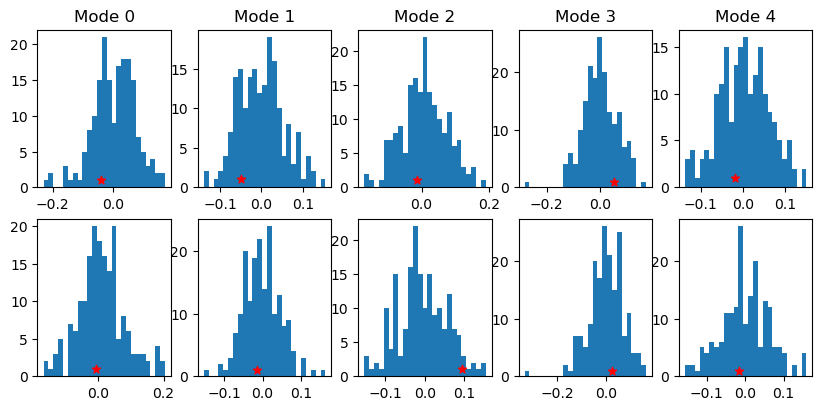

In [262]:
# First choose a truncation level:
# Third from right above looks good.
t = int(ts[-3]) 
Ut = U_or[:,0:t]
St = torch.diag(S[0:t])
Vht = Vh[0:t,:]

print(Vht.shape)

# How many example distributions to look at
t_viz = 10
plt.figure(figsize=(t_viz,4+0.5))
for i in range(t_viz):
    Vs = Vht[:,i]

    plt.subplot(2,t_viz//2,i+1)
    plt.hist(Vs,bins=25)
    plt.scatter(Vht[-1,i],1,marker='*',c='r')
    if i<t_viz//2:
        plt.title(f'Mode {i}')

In the above, we show the distribution of how the first few modes are weighted, across all images. We also show as an example how the last image is weighted. The purpose of looking at this last image is to try and see if the distributions are independent of each other. It's hard to tell, but it seems like they might be. Thus, we will carry along with the plan of sampling from these distributions. These distributions also look "close enough" to normal distributions. However, it's probably a **big** assumption to treat them all independently.

We will fit normal distributions to these parameter distributions, then sample from these distributions. Next, we will expand the sample from the low dimension latent space into a full image, by multiplying by our modes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

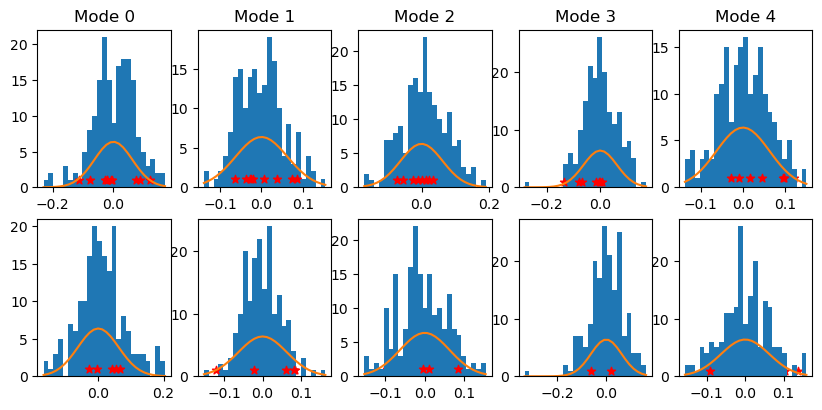

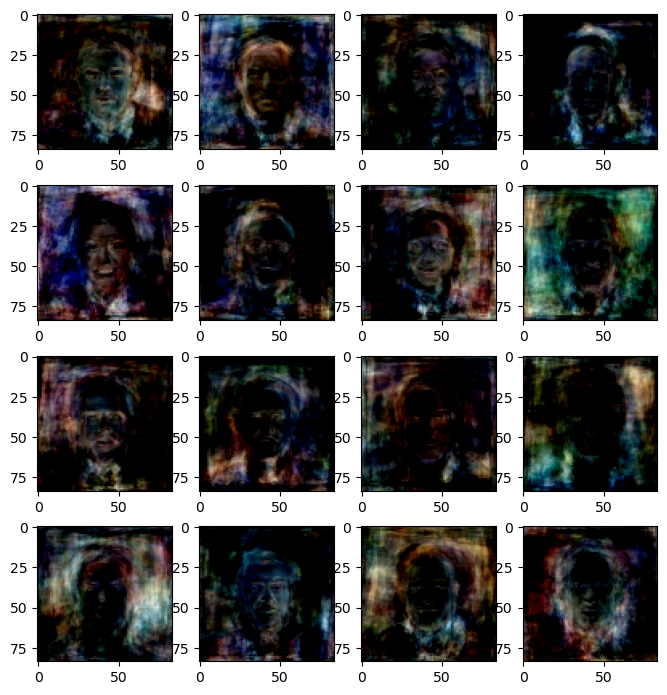

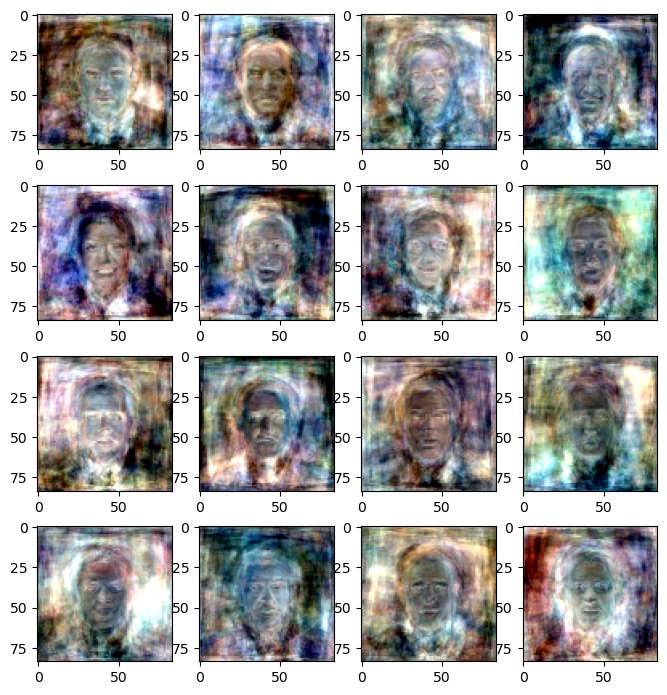

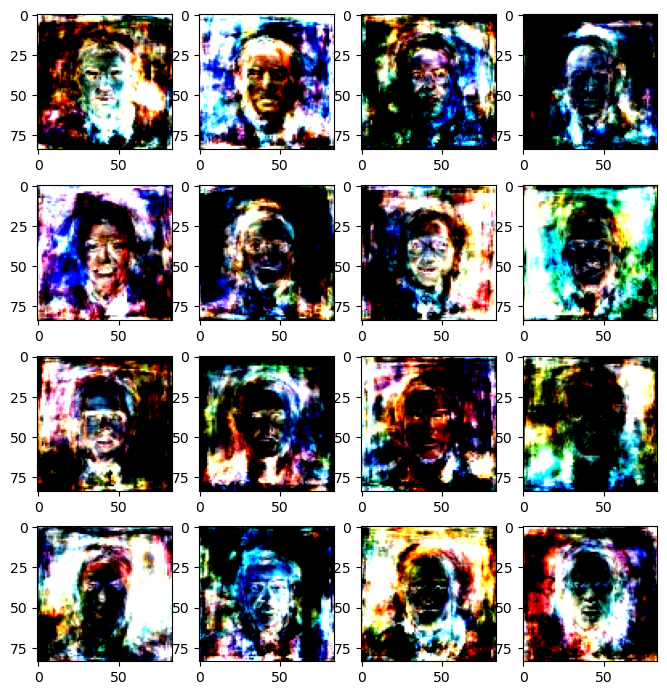

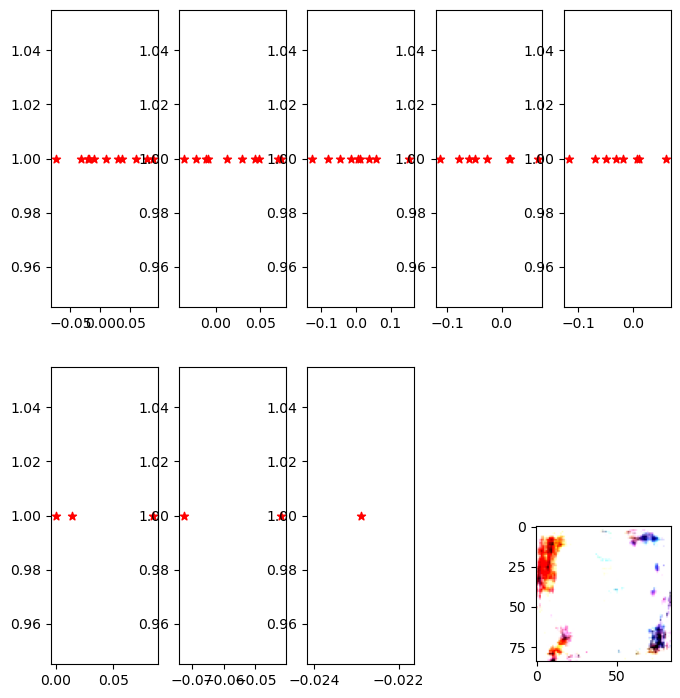

In [300]:
from scipy.stats import norm
# Compute mean and standard deviation across all images.
# This fully characterizes our normal distributions.
Vht_means = torch.mean(Vht,dim=1)
Vht_stdev = torch.std(Vht,dim=1)

color_list = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']*3

# Sample from these!
n_samples = 16
f = plt.figure(figsize=(t_viz,4+0.5))
f1 = plt.figure(figsize=(n_samples//4*2,8+0.5))
f2 = plt.figure(figsize=(n_samples//4*2,8+0.5))
f3 = plt.figure(figsize=(n_samples//4*2,8+0.5))
f4 = plt.figure(figsize=(n_samples//4*2,8+0.5))
for i in range(t_viz):
    Vs = Vht[:,i]

    # For vizualizing the normal distributions
    xs = np.linspace(torch.min(Vs),torch.max(Vs),30)

    plt.figure(f)
    plt.subplot(2,t_viz//2,i+1)
    plt.hist(Vs,bins=25)
    plt.plot(xs, norm.pdf(xs, Vht_means[i], Vht_stdev[i]))
    
    plt.plot()
    if i<t_viz//2:
        plt.title(f'Mode {i}')

    for sample in range(n_samples):
        Vht_s = torch.normal(Vht_means,Vht_stdev)
        for i in range(t_viz):
            0
            plt.subplot(2,t_viz//2,i+1)
            plt.scatter(Vht_s[i],1,marker='*',c='r')

        X_s1 = Ut @ St @ Vht_s

        # These are some alternative normalizations and ways of looking at it.
        # Remember, normal images have values on [0,1], but that restriction is not anywhere
        #  for this method! We need to enforce it ourselves.
        X_s2 = X_s1-torch.min(X_s1) / (torch.max(X_s1) - torch.min(X_s1))
        X_s3 = X_s1/torch.std(X_s1)
        X_s4 = X_s2/torch.std(X_s2)

        img_s1 = torch.reshape(X_s1,shape_subsample1)
        img_s2 = torch.reshape(X_s2,shape_subsample1)
        img_s3 = torch.reshape(X_s3,shape_subsample1)
        img_s4 = torch.reshape(X_s4,shape_subsample1)

        plt.figure(f1)
        plt.subplot(4,n_samples//4,sample+1)
        plt.imshow(torch.permute(img_s1[0,:,:,:],(1,2,0)))
        plt.figure(f2)
        plt.subplot(4,n_samples//4,sample+1)
        plt.imshow(torch.permute(img_s2[0,:,:,:],(1,2,0)))
        plt.figure(f3)
        plt.subplot(4,n_samples//4,sample+1)
        plt.imshow(torch.permute(img_s3[0,:,:,:],(1,2,0)))
        plt.figure(f4)
        plt.subplot(4,n_samples//4,sample+1)
        plt.imshow(torch.permute(img_s4[0,:,:,:],(1,2,0)))

### I've created some terrible monsters